# Reference envelop plots

Plots profiles reference envelop unsing PCM selection or not (as in Maze et al, 2017)

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas as pd

import pyxpcm
from pyxpcm.models import pcm

import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy.feature as cfeature
import cartopy.crs as ccrs

import argopy
argopy.set_options(src='localftp', local_ftp='/home/coriolis_exp/spool/co05/co0508/')
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

import scipy as sp
from scipy.io import loadmat
from scipy import interpolate

import seawater as sw

from classif_functions import *

__Input__

In [2]:
float_WMO = 4900136
prof_num = 80

## 1. Load float profile

using argopy

In [3]:
argo_loader = ArgoDataFetcher()
    
ds_f = argo_loader.profile(float_WMO, prof_num).to_xarray()
ds_f = ds_f.argo.point2profile()

In [4]:
ds_f

<xarray.Dataset>
Dimensions:                (N_LEVELS: 70, N_PROF: 1)
Coordinates:
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 5 6 ... 64 65 66 67 68 69
    LATITUDE               (N_PROF) float64 39.22
  * N_PROF                 (N_PROF) int64 0
    LONGITUDE              (N_PROF) float64 -62.58
    TIME                   (N_PROF) datetime64[ns] 2004-09-03T07:48:00
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int64 0
    CYCLE_NUMBER           (N_PROF) int64 80
    DATA_MODE              (N_PROF) <U1 'D'
    DIRECTION              (N_PROF) <U1 'A'
    PLATFORM_NUMBER        (N_PROF) int64 4900136
    POSITION_QC            (N_PROF) int64 1
    PRES                   (N_PROF, N_LEVELS) float64 9.0 19.6 ... 1.999e+03
    PRES_QC                (N_PROF) int64 1
    PSAL                   (N_PROF, N_LEVELS) float64 36.45 36.45 ... 34.94
    PSAL_QC                (N_PROF) int64 1
    TEMP                   (N_PROF, N_LEVELS) float64 26.68 26.67 ... 3.723
    TEMP_QC                (N_PROF) int64 1
    TIME_QC                (N_PROF) int64 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /home/coriolis_exp/spool/co05/co0508/
    Fetched_by:           agarciaj
    Fetched_date:         2021/08/17
    Fetched_constraints:  phy;WMO4900136_CYC80
    Fetched_uri:          /home/coriolis_exp/spool/co05/co0508//dac/meds/4900...
    history:              Variables filtered according to DATA_MODE; Variable...

In [5]:
pr = 0 # reference pressure in dbar
ds_f = ds_f.assign(ptmp=(["N_PROF", "N_LEVELS"], sw.ptmp(ds_f['PSAL'].values,ds_f['TEMP'].values,ds_f['PRES'].values,pr)))

In [6]:
ds_f

<xarray.Dataset>
Dimensions:                (N_LEVELS: 70, N_PROF: 1)
Coordinates:
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 5 6 ... 64 65 66 67 68 69
    LATITUDE               (N_PROF) float64 39.22
  * N_PROF                 (N_PROF) int64 0
    LONGITUDE              (N_PROF) float64 -62.58
    TIME                   (N_PROF) datetime64[ns] 2004-09-03T07:48:00
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int64 0
    CYCLE_NUMBER           (N_PROF) int64 80
    DATA_MODE              (N_PROF) <U1 'D'
    DIRECTION              (N_PROF) <U1 'A'
    PLATFORM_NUMBER        (N_PROF) int64 4900136
    POSITION_QC            (N_PROF) int64 1
    PRES                   (N_PROF, N_LEVELS) float64 9.0 19.6 ... 1.999e+03
    PRES_QC                (N_PROF) int64 1
    PSAL                   (N_PROF, N_LEVELS) float64 36.45 36.45 ... 34.94
    PSAL_QC                (N_PROF) int64 1
    TEMP                   (N_PROF, N_LEVELS) float64 26.68 26.67 ... 3.723
    TEMP_QC                (N_PROF) int64 1
    TIME_QC                (N_PROF) int64 1
    ptmp                   (N_PROF, N_LEVELS) float64 26.67 26.67 ... 3.595 3.56
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /home/coriolis_exp/spool/co05/co0508/
    Fetched_by:           agarciaj
    Fetched_date:         2021/08/17
    Fetched_constraints:  phy;WMO4900136_CYC80
    Fetched_uri:          /home/coriolis_exp/spool/co05/co0508//dac/meds/4900...
    history:              Variables filtered according to DATA_MODE; Variable...

In [7]:
ds_f.PRES.max().values

array(1999.)

## 2. Load reference data

from .mat files

In [8]:
file_path = 'mat_files/' + str(float_WMO) + '_prof' + str(prof_num) + '_refdata_class.mat'
mat_dict_load = sp.io.loadmat(file_path)

create a xarray dataset

In [9]:
ds_ref = xr.Dataset(
         data_vars=dict(
             pres=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_pres']),
             ptmp=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_ptmp']),
             sal=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_sal']),
         ),
         coords=dict(
             long=(["n_profiles"], np.squeeze(mat_dict_load['la_bhist_long'])),
             lat=(["n_profiles"], np.squeeze(mat_dict_load['la_bhist_lat'])),
             dates=(["n_profiles"], pd.to_datetime(list(map(str, map(int, np.squeeze(mat_dict_load['la_bhist_dates'])))))),
         ),
     )

In [10]:
ds_ref

<xarray.Dataset>
Dimensions:  (n_pres: 1029, n_profiles: 250)
Coordinates:
    long     (n_profiles) float64 297.9 292.3 292.3 295.6 ... 306.4 301.4 301.4
    lat      (n_profiles) float64 39.19 36.58 37.51 37.26 ... 40.69 41.23 40.47
    dates    (n_profiles) datetime64[ns] 2014-01-01 2006-01-01 ... 2010-01-01
Dimensions without coordinates: n_pres, n_profiles
Data variables:
    pres     (n_pres, n_profiles) float64 1.0 5.0 5.0 5.0 ... nan nan nan nan
    ptmp     (n_pres, n_profiles) float64 22.73 22.19 24.04 ... nan nan nan
    sal      (n_pres, n_profiles) float64 36.45 36.55 36.44 ... nan nan nan

In [11]:
print(np.min(ds_ref.pres.max(axis = 0).values))
print(np.max(ds_ref.pres.max(axis = 0).values))

999.7999877929688
2048.0


interpolation to standard levels??

In [17]:
max_depth = 1000
std_lev = np.arange(0,max_depth)
ds_out = interpolate_standard_levels(ds_ref, std_lev)

In [18]:
ds_out

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 1000, n_profiles: 250)
Coordinates:
    lat                (n_profiles) float64 39.19 36.58 37.51 ... 41.23 40.47
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 996 997 998 999
    long               (n_profiles) float64 297.9 292.3 292.3 ... 301.4 301.4
    dates              (n_profiles) datetime64[ns] 2014-01-01 ... 2010-01-01
Dimensions without coordinates: n_profiles
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 1.0 1.0 ... 999.0
    ptmp               (n_profiles, PRES_INTERPOLATED) float64 22.73 ... 5.93
    sal                (n_profiles, PRES_INTERPOLATED) float64 36.45 ... 35.05

Calculate mean and std

In [19]:
mean_ptmp = np.nanmean(ds_out['ptmp'], axis=0)
std_ptmp = np.nanstd(ds_out['ptmp'], axis=0)
mean_sal = np.nanmean(ds_out['sal'], axis=0)
std_sal = np.nanstd(ds_out['sal'], axis=0)

## 3. Plots

__Potential temperature__

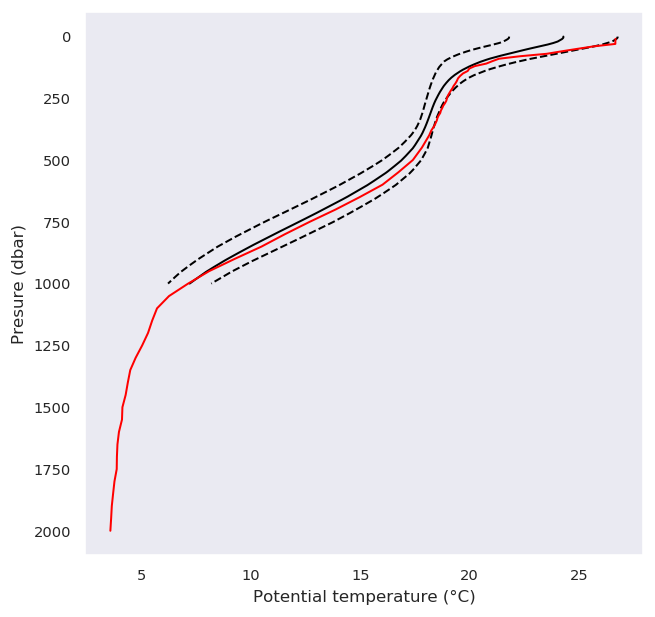

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            6, 6), dpi=120, facecolor='w', edgecolor='k')
ax.plot(mean_ptmp, ds_out['PRES_INTERPOLATED'].values, 'k');
ax.plot(mean_ptmp + std_ptmp, ds_out['PRES_INTERPOLATED'].values, 'k--');
ax.plot(mean_ptmp - std_ptmp, ds_out['PRES_INTERPOLATED'].values, 'k--');
ax.plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r');
plt.gca().invert_yaxis()
ax.set_ylabel('Presure (dbar)', fontsize=10);
ax.set_xlabel('Potential temperature (°C)', fontsize=10);

__Salinity__

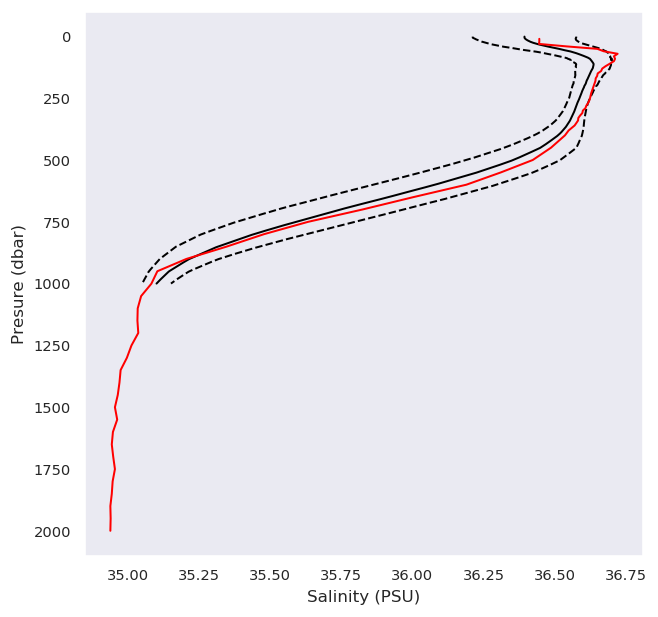

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            6, 6), dpi=120, facecolor='w', edgecolor='k')
ax.plot(mean_sal, ds_out['PRES_INTERPOLATED'].values, 'k');
ax.plot(mean_sal + std_sal, ds_out['PRES_INTERPOLATED'].values, 'k--');
ax.plot(mean_sal - std_sal, ds_out['PRES_INTERPOLATED'].values, 'k--');
ax.plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r');
plt.gca().invert_yaxis()
ax.set_ylabel('Presure (dbar)', fontsize=10);
ax.set_xlabel('Salinity (PSU)', fontsize=10);